In [103]:
## 1.0 Call libraries
# 1.1 Data wrangling
%reset -f
import pandas as pd
import numpy as np

#1.2 Keras libraries
from keras.layers import Input, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten,Embedding, GRU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# 1.3 For plotting model
from keras.utils import  plot_model

# 1.4 sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# 1.4 For model plotting
import matplotlib.pyplot as plt
import pydot
from skimage import io

# 1.5 Misc
import os
import time


In [104]:
## 2.0 Read Data
# 2.1
pathToData = "D:\ShreeTechnical\MLDL\Classes\EX\ex15"
os.chdir(pathToData)
# 2.2
data = pd.read_csv("train.tsv",sep='\t')
# 2.3 Inspect the data
print(data.shape)      
data.head(3)
data.tail(3)
data.dtypes           
data.columns.values   
# 2.4 Drop first column: 'train_id', being id column
data.drop(['train_id'], axis = 'columns' , inplace = True)

(1482535, 8)


In [105]:
# 2.5 Any missing value?
print(data.isnull().values.sum())        

# 2.6 Which columns?
print(data.columns[data.isnull().sum()  > 0])    

# 2.7 Let us follow a conservative and safe approach to fill missing values
data.category_name = data.category_name.fillna("missing")
data.brand_name = data.brand_name.fillna("missing")
data.item_description = data.item_description.fillna("missing")
data.isnull().values.sum()        

639013
Index(['category_name', 'brand_name', 'item_description'], dtype='object')


0

In [106]:
# 3 Divide data into train/test
dtrain,  dtest = train_test_split(data, test_size=0.30)

In [107]:
# 4. Which columns are 'object'
obj_columns = data.select_dtypes(include = ['object']).columns.values
print(obj_columns)

# 4.1 Which columns have numeric data
num = data.select_dtypes(include = ['int64', 'float64']).columns.values
num


['name' 'category_name' 'brand_name' 'item_description']


array(['item_condition_id', 'price', 'shipping'], dtype=object)

In [108]:
# Levels in columns: 'item_condition_id','shipping'
data.item_condition_id.value_counts()   

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

In [109]:
data.shipping.value_counts()    

0    819435
1    663100
Name: shipping, dtype: int64

In [110]:
for i in obj_columns:
    print(i,len(data[i].value_counts()))

name 1225273
category_name 1288
brand_name 4810
item_description 1281427


In [113]:
# 4.4 Final seven obj_columns for One Hot Encoding
obj_cols = ["item_condition_id", "shipping"]
ohe = OneHotEncoder()
# 4.4.1 Traing on dtrain
ohe = ohe.fit(dtrain[obj_cols])
# 4.4.2 Transform train (dtrain) and test (dtest) data
dtrain_ohe = ohe.transform(dtrain[obj_cols])
dtest_ohe = ohe.transform(dtest[obj_cols])
# 4.4.3
print (dtrain_ohe.shape)       
dtest_ohe.shape        

C:\Users\Shree\Shri\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(1037774, 7)


(444761, 7)

In [114]:
# 5.0 Label encode name and item_description
# 5.1 First 'name'
le = LabelEncoder()
le.fit(data["name"])                           
dtrain["nm"] = le.transform(dtrain['name'])    
dtest["nm"] = le.transform(dtest['name'])      

C:\Users\Shree\Shri\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Shree\Shri\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [115]:
# 5.2 Now 'item_description'
le = LabelEncoder()
le.fit(data["item_description"])                          
dtrain["ids"]= le.transform(dtrain['item_description'])   
dtest["ids"]= le.transform(dtest['item_description'])

C:\Users\Shree\Shri\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Shree\Shri\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [121]:
# 6. Finally transform two obj_columns category_name and brand_name for tokenization
te_cm = Tokenizer()
te_cm.fit_on_texts(data.category_name.values)
dtrain["cm"] = te_cm.texts_to_sequences(dtrain.category_name)
dtest["cm"] = te_cm.texts_to_sequences(dtest.category_name)

te_bn = Tokenizer()
te_bn.fit_on_texts(data.brand_name.values)
dtrain["bn"] = te_bn.texts_to_sequences(dtrain.brand_name)
dtest["bn"] = te_bn.texts_to_sequences(dtest.brand_name)

C:\Users\Shree\Shri\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Shree\Shri\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Shree\Shri\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [122]:
dtrain.shape

(1037774, 11)

In [123]:
dtest.shape

(444761, 11)

In [124]:
# 8. Get max length of the sequences
##
maxlen_cm = 0
for i in dtrain["cm"]:
	if maxlen_cm < len(i):
		maxlen_cm = len(i)

for i in dtest["cm"]:
	if maxlen_cm < len(i):
		maxlen_cm = len(i)

print(maxlen_cm)     
##
maxlen_bn = 0
for i in dtrain["bn"]:
	if maxlen_bn < len(i):
		maxlen_bn = len(i)

for i in dtest["bn"]:
	if maxlen_bn < len(i):
		maxlen_bn = len(i)

maxlen_bn     

8


8

In [144]:
one = np.max([np.max(i) for i in dtrain["cm"].tolist() ])
two = np.max([np.max(i) for i in dtest["cm"].tolist() ])
MAX_VOCAB_CM = np.max([one,two])
print(MAX_VOCAB_CM)
one = np.max([np.max(i) for i in dtrain["bn"].tolist() ])
two = np.max([np.max(i) for i in dtest["bn"].tolist() ])
MAX_VOCAB_BN = np.max([one,two])
print(MAX_VOCAB_BN)

1022
5117


In [145]:
#MAX_VOCAB_NM = len(dtrain.name.value_counts())
MAX_VOCAB_NM1 = np.max(dtrain["nm"])
print(MAX_VOCAB_NM1)
#MAX_VOCAB_ID = len(dtrain.item_description.value_counts())
MAX_VOCAB_ID1 = np.max(dtrain["ids"])
MAX_VOCAB_ID1
#MAX_VOCAB_NM = len(dtrain.name.value_counts())
MAX_VOCAB_NM2 = np.max(dtest["nm"])
print(MAX_VOCAB_NM2)
#MAX_VOCAB_ID = len(dtrain.item_description.value_counts())
MAX_VOCAB_ID2 = np.max(dtest["ids"])
MAX_VOCAB_ID2
MAX_VOCAB_ID = np.max([MAX_VOCAB_ID1,MAX_VOCAB_ID2])
MAX_VOCAB_NM = np.max([MAX_VOCAB_NM1,MAX_VOCAB_NM2])
print(MAX_VOCAB_ID)
print(MAX_VOCAB_NM)

1225268
1225272
1281426
1225272


In [146]:
# 10.1 Training data
Xtr = {
	"ohe" : dtrain_ohe.toarray(),        # Note the name 'ohe'
	"cm"  : pad_sequences(dtrain.cm, maxlen=maxlen_cm),
	"bn"  : pad_sequences(dtrain.bn, maxlen=maxlen_bn),
    "nm"  : dtrain["nm"].values,
	"ids" : dtrain["ids"].values,
      }

# 10.2 Test data
Xte = {
	"ohe" : dtest_ohe.toarray(),
	"cm"  : pad_sequences(dtest.cm, maxlen=maxlen_cm),
	"bn"  : pad_sequences(dtest.bn, maxlen=maxlen_bn),
    "nm"  : dtest["nm"].values,
	"ids" : dtest["ids"].values,
      }

In [147]:
print(Xtr["ohe"].shape)        
print(Xtr["nm"].shape)         
print(Xtr["cm"].shape)         
print(Xtr["bn"].shape)         
print(Xtr["ids"].shape)         

(1037774, 7)
(1037774,)
(1037774, 8)
(1037774, 8)
(1037774,)


In [148]:
# 11. Design a simple model now

ohe =  Input(shape= (Xtr["ohe"].shape[1], ),name = "ohe" )

nm =   Input(shape= [1],name = "nm")

ids =   Input(shape= [1],name = "ids")

cm =   Input(shape= (Xtr["cm"].shape[1],),name = "cm")

bn =   Input(shape= (Xtr["bn"].shape[1],),name = "bn")

In [149]:
emb_cm  =      Embedding(MAX_VOCAB_CM+ 1 ,      32  )(cm)
emb_bn  =      Embedding(MAX_VOCAB_BN+ 1 ,      32  )(bn)
emb_nm  =      Embedding(MAX_VOCAB_NM+ 1 ,      32  )(nm)
emb_ids  =      Embedding(MAX_VOCAB_ID+ 1 ,      32  )(ids)

In [150]:
rnn_cm = GRU(16) (emb_cm)
rnn_bn = GRU(16) (emb_bn)

In [151]:
model = Model([ohe,nm,cm,bn,ids], [ohe, emb_nm, rnn_cm, rnn_bn, emb_ids])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cm (InputLayer)                 (None, 8)            0                                            
__________________________________________________________________________________________________
bn (InputLayer)                 (None, 8)            0                                            
__________________________________________________________________________________________________
nm (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 8, 32)        32736       cm[0][0]                         
__________________________________________________________________________________________________
embedding_

In [152]:
class_l = concatenate([
                      rnn_cm,        # GRU output is already 1D
                      rnn_bn,
                      ohe,           # 1D output
					  Flatten()(emb_nm),   
					  Flatten()(emb_ids)
                      ]
                     )

In [153]:
class_l = Dense(64) (class_l)
class_l = Dropout(0.1)(class_l)
class_l = Dense(32) (class_l)
class_l = Dropout(0.1) (class_l)

In [154]:
output = Dense(1, activation="linear") (class_l)

In [155]:
model = Model(
              inputs= [ohe, nm, cm, bn, ids],
              outputs= output
             )

In [156]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cm (InputLayer)                 (None, 8)            0                                            
__________________________________________________________________________________________________
bn (InputLayer)                 (None, 8)            0                                            
__________________________________________________________________________________________________
nm (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
ids (InputLayer)                (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

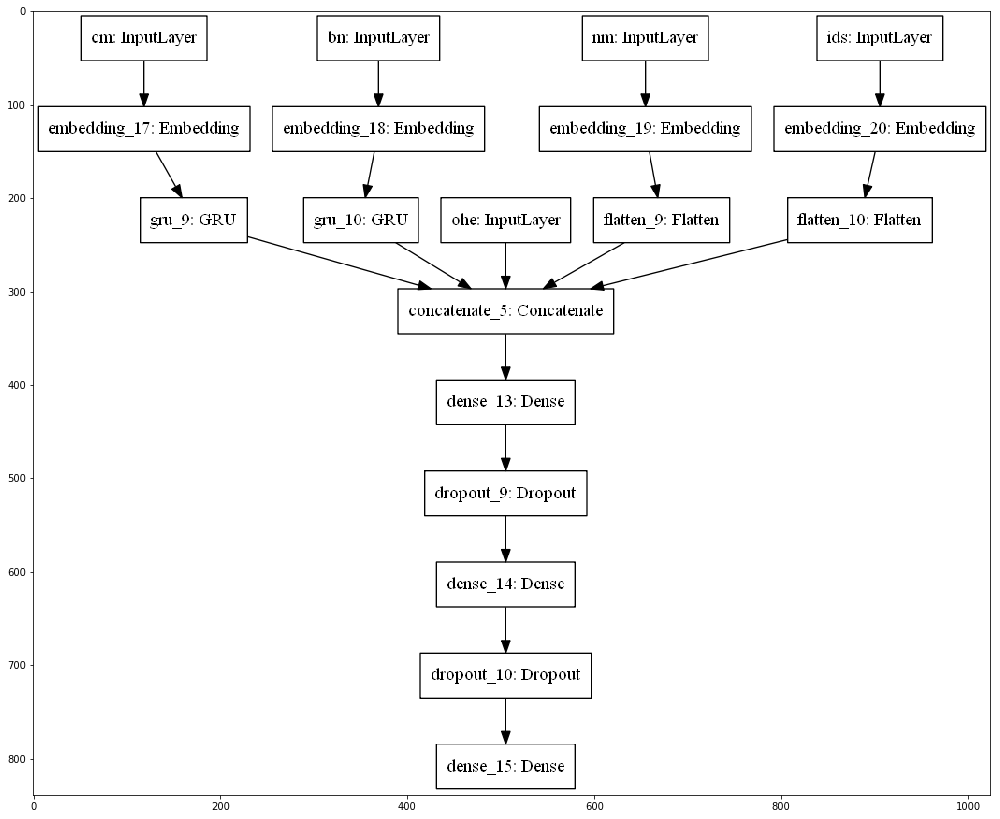

In [157]:
plt.figure(figsize = (14,14))
plot_model(model, to_file = "model.png")
io.imshow("model.png")

In [158]:
model.compile(loss="mse",
              optimizer="adam",
              metrics=["mae"]
			  )

In [161]:
BATCH_SIZE = 50000
epochs = 20

In [162]:
start = time.time()
history= model.fit(Xtr,
                   dtrain.price,
                   epochs=epochs,
                   batch_size=BATCH_SIZE,
				   validation_data=(Xte, dtest.price),
				   verbose = 1
                  )
end = time.time()
print((end-start)/60)

Train on 1037774 samples, validate on 444761 samples
Epoch 1/20
1037774/1037774 [==============================] - 46s 44us/step - loss: 1131.8314 - mean_absolute_error: 13.9341 - val_loss: 1107.0508 - val_mean_absolute_error: 14.7036
Epoch 2/20
1037774/1037774 [==============================] - 46s 44us/step - loss: 994.2482 - mean_absolute_error: 11.7402 - val_loss: 1072.8570 - val_mean_absolute_error: 15.1461
Epoch 3/20
1037774/1037774 [==============================] - 47s 46us/step - loss: 828.5545 - mean_absolute_error: 9.4948 - val_loss: 1066.2321 - val_mean_absolute_error: 16.1182
Epoch 4/20
1037774/1037774 [==============================] - 47s 45us/step - loss: 671.4686 - mean_absolute_error: 8.1758 - val_loss: 1102.7563 - val_mean_absolute_error: 17.8262
Epoch 5/20
1037774/1037774 [==============================] - 48s 46us/step - loss: 545.1450 - mean_absolute_error: 7.4110 - val_loss: 1164.7894 - val_mean_absolute_error: 19.5284
Epoch 6/20
1037774/1037774 [================